In [100]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score , confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from textblob import TextBlob
from nltk import download

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
download('stopwords')
download('punkt')
download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [102]:
files = [
    "politifact_fake.csv",
    "politifact_real.csv",
    "gossipcop_fake.csv",
    "gossipcop_real.csv",
]

In [103]:
dataframes = []
for file in files:
    df = pd.read_csv(file)
    df['label'] = 1 if 'real' in file else 0  # Assign label: 1 for real, 0 for fake
    dataframes.append(df)

In [104]:
df = pd.concat(dataframes, ignore_index=True)

Cleaning: Had to look up for tags, spaces and Special Characters.

In [105]:
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Normalizing text
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [106]:
df['cleaned_title'] = df['title'].apply(preprocess_text)

In [107]:
"""# TF-IDF Vectorization for Text
vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 features
X = vectorizer.fit_transform(df['cleaned_title']).toarray()
y = df['label']  # Labels"""

"# TF-IDF Vectorization for Text\nvectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 features\nX = vectorizer.fit_transform(df['cleaned_title']).toarray()\ny = df['label']  # Labels"

In [108]:
nlp = spacy.load("en_core_web_sm")

In [109]:
def extract_entities(text):
    doc = nlp(text)
    entity_counts = {'ORG': 0, 'GPE': 0, 'PERSON': 0}
    for ent in doc.ents:
        if ent.label_ in entity_counts:
            entity_counts[ent.label_] += 1
    return entity_counts

In [110]:
df['entities'] = df['cleaned_title'].apply(extract_entities)

In [111]:
df['org_count'] = df['entities'].apply(lambda x: x['ORG'])
df['gpe_count'] = df['entities'].apply(lambda x: x['GPE'])
df['person_count'] = df['entities'].apply(lambda x: x['PERSON'])

In [112]:
df['title_length'] = df['cleaned_title'].apply(lambda x: len(x.split()))
df['sentiment'] = df['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [113]:
# Final feature set
features = ['org_count', 'gpe_count', 'person_count', 'title_length', 'sentiment']
X = df[features]
y = df['label']  # Real vs Fake labels

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [124]:
model = [
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=500)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Support Vector Machine", SVC(kernel='linear', random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5)),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
        ]

results = {}

# Evaluation
for model_name, model in model:
    print(f"Training {model_name}...")
    # Train the model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    results[model_name] = accuracy

Training Logistic Regression...
Accuracy for Logistic Regression: 0.75
              precision    recall  f1-score   support

           0       0.39      0.00      0.01      1731
           1       0.75      1.00      0.86      5228

    accuracy                           0.75      6959
   macro avg       0.57      0.50      0.43      6959
weighted avg       0.66      0.75      0.65      6959

Training Random Forest...
Accuracy for Random Forest: 0.74
              precision    recall  f1-score   support

           0       0.37      0.09      0.15      1731
           1       0.76      0.95      0.84      5228

    accuracy                           0.74      6959
   macro avg       0.56      0.52      0.49      6959
weighted avg       0.66      0.74      0.67      6959

Training Support Vector Machine...
Accuracy for Support Vector Machine: 0.75
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1731
           1       0.75      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy for K-Nearest Neighbors: 0.72
              precision    recall  f1-score   support

           0       0.34      0.12      0.18      1731
           1       0.76      0.92      0.83      5228

    accuracy                           0.72      6959
   macro avg       0.55      0.52      0.51      6959
weighted avg       0.66      0.72      0.67      6959

Training XGBoost...
Accuracy for XGBoost: 0.75
              precision    recall  f1-score   support

           0       0.49      0.04      0.07      1731
           1       0.76      0.99      0.86      5228

    accuracy                           0.75      6959
   macro avg       0.62      0.51      0.46      6959
weighted avg       0.69      0.75      0.66      6959



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [116]:
print("\nModel Performance Comparison:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.2f}")


Model Performance Comparison:
Logistic Regression: 0.75
Random Forest: 0.74
Support Vector Machine: 0.75
K-Nearest Neighbors: 0.72
XGBoost: 0.75


6. Visualization

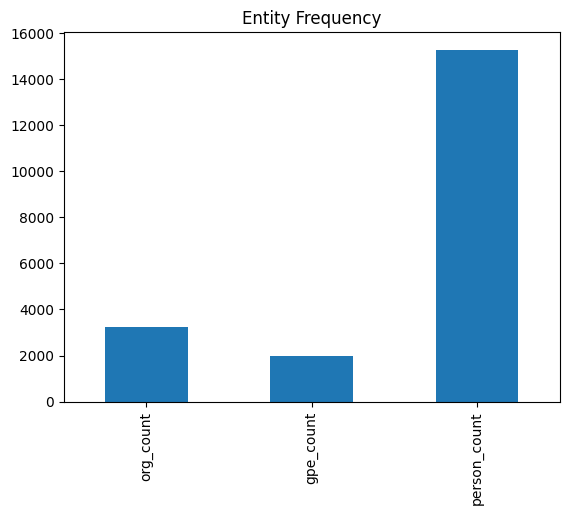

In [117]:
entity_counts = df[['org_count', 'gpe_count', 'person_count']].sum()
entity_counts.plot(kind='bar', title="Entity Frequency")
plt.show()


<ipython-input-120-4f596ee0b75d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


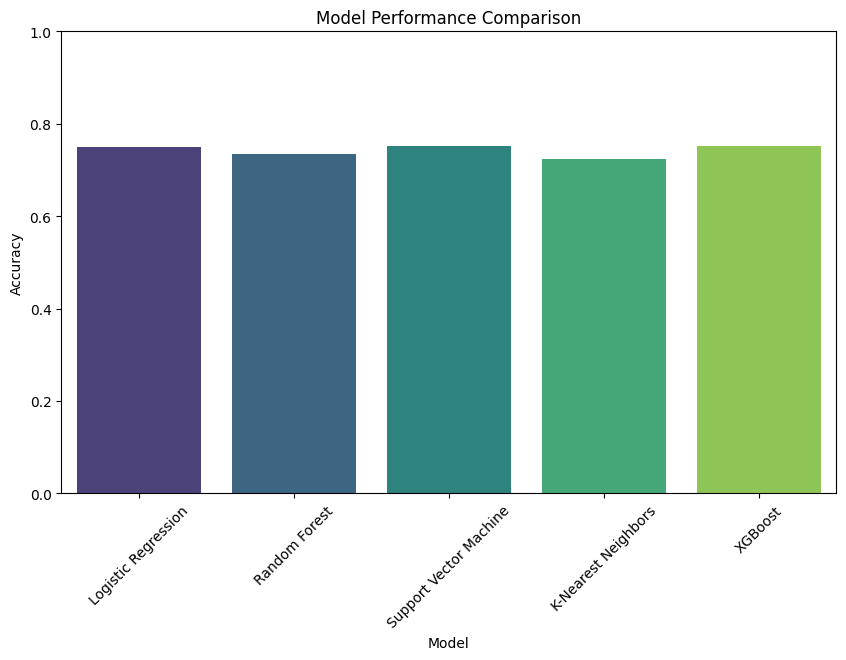

In [120]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()
